<a href="https://colab.research.google.com/github/nayakanuj/QAP/blob/main/BPQM_in_qiskit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Belief Propagation with Quantum Messages in Qiskit.**

This notebook is based on belief propagation with quantum messages for quantum-enhanced classical communication from the following paper:
Rengaswamy, Narayanan, Kaushik P. Seshadreesan, Saikat Guha, and Henry D. Pfister. "[Belief propagation with quantum messages for quantum-enhanced classical communications.](https://www.nature.com/articles/s41534-021-00422-1)" npj Quantum Information 7.1 (2021): 97.

The approach builds on the concept of belief propagation, which is a classical algorithm for computing marginal probabilities of a graphical model. It is a popular decoding technique for messages encoded using LDPC codes. The key idea of quantum belief propagation is to interpret message-combining of classical belief propagation as "channel combining" rules, which allows for quantum messages. Local inference is performed using suitable unitary operations, whose outputs are quantum messages.

In this notebook, we will implement Belief Propagation with Quantum Messages in Qiskit.

In [ ]:
!pip install qiskit
!pip install pylatexenc

In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import matplotlib.pyplot as plt
from qiskit.visualization import *
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import *
from qiskit import Aer
from qiskit import execute
from qiskit.visualization import plot_histogram
from qiskit import transpile
import qiskit.quantum_info as qi
import pandas as pd
import os
%matplotlib inline

# `Utils` class contains methods to obtain unitary matrices corresponding to channel combining at **variable** and **factor nodes.**

In [3]:
class Utils():
    @staticmethod
    def get_codebook():
        cb = []
        # parity_check_mtx = np.array([[1, 1, 1, 0, 0],
        #                    [1, 0, 0, 1, 1]])
        generator_mtx = np.array([[0, 0, 0, 1, 1],
                                  [0, 1, 1, 0, 0],
                                  [1, 0, 1, 0, 1]])
        for ind_cwd in range(2 ** 3):
            binary_digits = np.array([int(digit) for digit in np.binary_repr(ind_cwd, width=3)])
            cb.append([x % 2 for x in binary_digits.T @ generator_mtx])

        return cb

    @staticmethod
    def get_var_node_conv_unitary_matrix(theta1, theta2):

        theta_p = (theta1 + theta2) / 2
        theta_m = (theta1 - theta2) / 2

        a = lambda sgn: (np.cos(theta_m) + sgn * np.cos(theta_p)) / np.sqrt(2 * (1 + np.cos(theta1) * np.cos(theta2)))
        a_plus = a(1)
        a_minus = a(-1)
        b = lambda sgn: (np.sin(theta_p) - sgn * np.sin(theta_m)) / np.sqrt(2 * (1 - np.cos(theta1) * np.cos(theta2)))
        b_plus = b(1)
        b_minus = b(-1)

        unitary_matrix = np.array([[a_plus, 0.0, 0.0, a_minus],
                          [a_minus, 0.0, 0.0, -a_plus],
                          [0.0, b_plus, b_minus, 0.0],
                          [0.0, b_minus, -b_plus, 0.0]])

        return unitary_matrix

    @staticmethod
    def apply_conditional_unitary_gate_U(qc, qr, theta0, theta1, inverse_flag=0):

        U_mtx00 = Utils.get_var_node_conv_unitary_matrix(theta0, theta0)
        U_gate00 = UnitaryGate(U_mtx00, label="$U_{\\theta0, \\theta0}$").control(2, ctrl_state='00')
        U_gate00_inv = UnitaryGate(np.conj(U_mtx00).T, label="$U_{\\theta0, \\theta0}^{\dagger}$").control(2, ctrl_state='00')
        U_mtx01 = Utils.get_var_node_conv_unitary_matrix(theta0, theta1)
        U_gate01 = UnitaryGate(U_mtx01, label="$U_{\\theta0, \\theta1}$").control(2, ctrl_state='01')
        U_gate01_inv = UnitaryGate(np.conj(U_mtx01).T, label="$U_{\\theta0, \\theta1}^{\dagger}$").control(2, ctrl_state='01')
        U_mtx10 = Utils.get_var_node_conv_unitary_matrix(theta1, theta0)
        U_gate10 = UnitaryGate(U_mtx10, label="$U_{\\theta1, \\theta0}$").control(2, ctrl_state='10')
        U_gate10_inv = UnitaryGate(np.conj(U_mtx10).T, label="$U_{\\theta1, \\theta0}^{\dagger}$").control(2, ctrl_state='10')
        U_mtx11 = Utils.get_var_node_conv_unitary_matrix(theta1, theta1)
        U_gate11 = UnitaryGate(U_mtx11, label="$U_{\\theta1, \\theta1}$").control(2, ctrl_state='11')
        U_gate11_inv = UnitaryGate(np.conj(U_mtx11).T, label="$U_{\\theta1, \\theta1}^{\dagger}$").control(2, ctrl_state='11')
        if inverse_flag:
            qc.append(U_gate11_inv, [qr[3], qr[4], qr[2], qr[1]])            
            qc.append(U_gate10_inv, [qr[3], qr[4], qr[2], qr[1]])                        
            qc.append(U_gate01_inv, [qr[3], qr[4], qr[2], qr[1]])                        
            qc.append(U_gate00_inv, [qr[3], qr[4], qr[2], qr[1]])
        else:
            qc.append(U_gate00, [qr[3], qr[4], qr[2], qr[1]])
            qc.append(U_gate01, [qr[3], qr[4], qr[2], qr[1]])
            qc.append(U_gate10, [qr[3], qr[4], qr[2], qr[1]])
            qc.append(U_gate11, [qr[3], qr[4], qr[2], qr[1]])

        return qc

    @staticmethod
    def apply_conditional_unitary_gate_V(qc, qr, theta, theta00, inverse_flag=0):

        V_mtx00 = Utils.get_var_node_conv_unitary_matrix(theta, theta00)
        V_gate00 = UnitaryGate(V_mtx00, label="$V_{\\theta, \\theta00}$").control(2, ctrl_state='00')
        V_gate00_inv = UnitaryGate(np.conj(V_mtx00).T, label="$V_{\\theta, \\theta00}^{\dagger}$").control(2, ctrl_state='00')
        V_mtx01 = Utils.get_var_node_conv_unitary_matrix(theta, np.pi / 2)
        V_gate01 = UnitaryGate(V_mtx01, label="$V_{\\theta, \pi/2}$").control(2, ctrl_state='01')
        V_gate01_inv = UnitaryGate(np.conj(V_mtx01).T, label="$V_{\\theta, \pi/2}^{\dagger}$").control(2, ctrl_state='01')
        V_mtx10 = Utils.get_var_node_conv_unitary_matrix(theta, np.pi / 2)
        V_gate10 = UnitaryGate(V_mtx10, label="$V_{\\theta, \pi/2}$").control(2, ctrl_state='10')
        V_gate10_inv = UnitaryGate(np.conj(V_mtx10).T, label="$V_{\\theta, \pi/2}^{\dagger}$").control(2, ctrl_state='10')
        V_mtx11 = Utils.get_var_node_conv_unitary_matrix(theta, np.pi / 2)
        V_gate11 = UnitaryGate(V_mtx11, label="$V_{\\theta, \pi/2}$").control(2, ctrl_state='11')
        V_gate11_inv = UnitaryGate(np.conj(V_mtx11).T, label="$V_{\\theta, \pi/2}^{\dagger}$").control(2, ctrl_state='11')

        if inverse_flag:
            qc.append(V_gate11_inv, [qr[3], qr[4], qr[1], qr[0]])                        
            qc.append(V_gate10_inv, [qr[3], qr[4], qr[1], qr[0]])                        
            qc.append(V_gate01_inv, [qr[3], qr[4], qr[1], qr[0]])                      
            qc.append(V_gate00_inv, [qr[3], qr[4], qr[1], qr[0]])
        else:
            qc.append(V_gate00, [qr[3], qr[4], qr[1], qr[0]])
            qc.append(V_gate01, [qr[3], qr[4], qr[1], qr[0]])
            qc.append(V_gate10, [qr[3], qr[4], qr[1], qr[0]])
            qc.append(V_gate11, [qr[3], qr[4], qr[1], qr[0]])

        return qc

    @staticmethod
    def apply_conditional_rotation_K(qc, qr, cr, phi00):

        sin_plus_cos = np.cos(phi00 / 2) + np.sin(phi00 / 2)
        sin_minus_cos = np.sin(phi00 / 2) - np.cos(phi00 / 2)
        cos_minus_sin = np.cos(phi00 / 2) - np.sin(phi00 / 2)
        Kp = (1 / np.sqrt(2)) * np.array([[sin_plus_cos, cos_minus_sin],
                                          [sin_minus_cos, sin_plus_cos]])
        Km = (1 / np.sqrt(2)) * np.array([[sin_plus_cos, sin_minus_cos],
                                          [cos_minus_sin, sin_plus_cos]])

        Kp_gate = UnitaryGate(Kp, label="$K_{+}$").control(3, ctrl_state='000')
        Km_gate = UnitaryGate(Km, label="$K_{-}$").control(3, ctrl_state='001')

        qc.x(qr[5]).c_if(cr[0], 1)

        qc.append(Kp_gate, [qr[5], qr[4], qr[3], qr[0]])
        qc.append(Km_gate, [qr[5], qr[4], qr[3], qr[0]])

        return qc

    @staticmethod
    def apply_conditional_unitary_gate_U2345(qc, theta, qregs=[1, 2]):

        U_p_mtx = Utils.get_var_node_conv_unitary_matrix(theta, theta)
        U_p = UnitaryGate(U_p_mtx, label="$U_{+}$").control(1, ctrl_state='0')
        U_m_mtx = Utils.get_var_node_conv_unitary_matrix(-theta, theta)
        U_m = UnitaryGate(U_m_mtx, label="$U_{-}$").control(1, ctrl_state='1')

        qc.append(U_p, qregs)
        qc.append(U_m, qregs)

        return qc

    @staticmethod
    def get_channel_output(theta=0.5 * 3.142, codeword_idx=2):
        # Initialize - get codebook, decoder input
        codebook = Utils.get_codebook()
        codeword = codebook[codeword_idx]  # choose a codeword from codebook

        q_theta_plus = Statevector([np.cos(theta / 2), np.sin(theta / 2)])
        q_theta_minus = Statevector([np.cos(theta / 2), -np.sin(theta / 2)])

        # Decoder input - statevector
        decoder_input = Statevector([1, 0])
        for ind in reversed(range(5)):
            decoder_input = decoder_input.tensor(q_theta_plus if codeword[ind] == 0 else q_theta_minus)

        return decoder_input

# `Visualizer`: multi-bloch vector representation, schematic of a quantum circuit.
# `Debug`: methods to print, unitary, partial trace.

In [4]:
class Visualizer():
    @staticmethod
    def my_plot_statevector(qc, label="", filename=""):
        backend1 = Aer.get_backend('statevector_simulator')
        job = backend1.run(transpile(qc, backend1))
        result = job.result()
        outputstate = result.get_statevector(qc)
        plot_bloch_multivector(outputstate, title=label, filename=filename)
        plt.show()


    @staticmethod
    def my_plot_statecity(qc, label=""):
        backend1 = Aer.get_backend('statevector_simulator')
        job = backend1.run(transpile(qc, backend1))
        result = job.result()
        outputstate = result.get_statevector(qc)
        plot_state_city(outputstate, title=label)
        plt.show()
      
    @staticmethod
    def print_message(viz_params):
        print(f"Plots are saved in {viz_params['plot_foldername']} folder")


    @staticmethod
    def draw_circuit(qc):
        qc.draw(output = "mpl")
        #plt.show()

class Debug():
    @staticmethod
    def print_statevector(qc, label=""):
        stv = qi.Statevector.from_instruction(qc)
        stv.draw('latex', prefix=label + ':')
        return stv

    @staticmethod
    def get_unitary(qc):
        backend1 = Aer.get_backend('unitary_simulator')
        job = backend1.run(transpile(qc, backend1))
        result = job.result()
        unitary_mtx = result.get_unitary(qc)

        return unitary_mtx

    @staticmethod
    def get_partial_trace_density_matrix(qc, subset=[5]):
        rho = execute(qc, Aer.get_backend('statevector_simulator')).result().get_statevector()
        rho_traced = partial_trace(rho, subset)

        return rho_traced
    

$$\require{physics}$$

# **BPQM Circuit**
Classical data is transmitted over a pure-loss classical-quantum channel (which adds only non-orthogonality as an impairment).
### **Pure-state classical-quantum channel**
The pure-loss classical-quantum (CQ) channel is defined by the following map: $W:\{0,1\} \rightarrow \{ \vert{\theta} \rangle \langle{\theta}\vert, \vert{-\theta} \rangle \langle{-\theta}\vert \}$.
$W(x) := \vert{\theta}\rangle \langle 0 \vert \vert x\rangle \langle x \vert  \vert 0 \rangle \langle{\theta}\vert + \vert{-\theta}\rangle \langle 1 \vert \vert x \rangle \langle x \vert  \vert 1 \rangle \langle{-\theta}\vert $
where , and $\vert{\pm\theta\rangle} = \cos\frac{\theta}{2} \vert 0\rangle \pm \sin \frac{\theta}{2} \vert{1}\rangle $ are the non-orthogonal states.

### **BPQM Circuit**
The BPQM circuit performs belief propagation decoding in 5 stages:
#### 1.   **Channel combining operation at FN:**

Channel combining operation at a factor node is performed by applying a CNOT gate.

*Note: In the quantum circuit figure below (obtained after building quantum circuit), CNOT gates after the first barrier indicate FN channel combining operations.*

#### 2.   **Channel combining operation at VN:**

$
U_{\circledast}\left(\theta', \theta''\right):=\left[\begin{array}{cccc}a_{+} & 0 & 0 & a_{-} \\a_{-} & 0 & 0 & -a_{+} \\0 & b_{+} & b_{-} & 0 \\0 & b_{-} & -b_{+} & 0\end{array}\right],$

where 
$a_{\pm}:=\frac{1}{\sqrt{2}} \frac{\cos \left(\frac{\theta'-\theta''}{2}\right) \pm \cos \left(\frac{\theta'+\theta''}{2}\right)}{\sqrt{1+\cos \theta' \cos \theta''}}, \quad b_{\pm}:=\frac{1}{\sqrt{2}} \frac{\sin \left(\frac{\theta'+\theta''}{2}\right) \mp \sin \left(\frac{\theta'-\theta''}{2}\right)}{\sqrt{1-\cos \theta' \cos \theta''}}$.

*Note: In the quantum circuit figure below, unitaries $U_{\theta0, \theta0}$ through $V_{\theta, \pi/2}$ indicate VN channel combining operations.
In the figure, angles are computed as: $cos(\theta_{0}) = \left(\frac{2 cos(\theta)}{1 + cos(\theta)^2}\right)$, 
$\theta_1 = \pi/2$, 
$cos(\theta_{00}) = cos(\theta_0)^2$.*

#### 3.   **Measuring q0**
q0 is measured in Bell-basis - indicated by a Hadamard gate followed by a measurement in compuational basis.

#### 4.   **Undoing measurement and channel combining:**
q0 measurement is undone by conditional roations $K_{+}$ and $K_{-}$, conditioned on the q0 measurement being 0 and 1, respectively.

$K_{+}:=\left[\begin{array}{cc} cos\frac{\phi_{00}}{2}+sin\frac{\phi_{00}}{2} & cos\frac{\phi_{00}}{2}-sin\frac{\phi_{00}}{2} \\sin\frac{\phi_{00}}{2}-cos\frac{\phi_{00}}{2} & cos\frac{\phi_{00}}{2}+sin\frac{\phi_{00}}{2} \end{array}\right]$

$K_{-}:=\left[\begin{array}{cc} cos\frac{\phi_{00}}{2}+sin\frac{\phi_{00}}{2} & sin\frac{\phi_{00}}{2}-cos\frac{\phi_{00}}{2} \\ cos\frac{\phi_{00}}{2}-sin\frac{\phi_{00}}{2} & cos\frac{\phi_{00}}{2}+sin\frac{\phi_{00}}{2} \end{array}\right]$

*Note: In the quantum circuit figure below, $cos(\phi_{00}) = cos(\theta) cos(\theta_{00})$*.

#### 5.   **Decoding q1 to q4:**
$(x_2, x_3)$ and $(x_4, x_5)$ can be decoded independently, since they are independent given $x_1$ in the factor graph. This is achieved by applying unitaries (channel combining at VN) on (q1, q2) and (q3, q4), followed by Bell measurements on q2 and q4, respectively.


In [5]:
class BPQM_Circuit():
    def __init__(self, channel_output, theta, viz_params):

        self.viz_params = viz_params

        codebook = Utils.get_codebook()
        self.codeword = codebook[7]

        self.theta = theta
        self.theta0 = np.arccos(2 * np.cos(theta) / (1 + np.cos(theta) ** 2))
        self.theta1 = np.pi / 2
        self.theta00 = np.arccos(np.cos(self.theta0) ** 2)

        self.cr = ClassicalRegister(3, name="c")
        self.qr = QuantumRegister(6, name="q")

        self.qc = QuantumCircuit(self.qr, self.cr)
        # State preparation - channel outputs (pure-state channel)
        print("State preparation...")
        self.qc.initialize(channel_output, self.qr)
        self.qc.barrier(self.qr)

        if self.viz_params['visualize_flag']:
            if not os.path.exists(viz_params['plot_foldername']):
              os.makedirs(viz_params['plot_foldername'])
              print(f"Folder {viz_params['plot_foldername']} created.")
            Visualizer.my_plot_statevector(self.qc, label="decoder input", filename=self.viz_params['plot_foldername'] + self.viz_params['plot_filename_prefix'] + "_decoder_input.png")

    def channel_combining_at_FN(self):
        print("Applying channel combining at factor node...")
        # Decoding bit 0
        self.qc.cnot(self.qr[1], self.qr[2])
        self.qc.cnot(self.qr[3], self.qr[4])
        self.qc.swap(self.qr[2], self.qr[3])

        if self.viz_params['visualize_flag']:
            Visualizer.my_plot_statevector(self.qc, label="after channel combining at FN (CNOT)", filename=self.viz_params['plot_foldername'] + self.viz_params['plot_filename_prefix'] + "_FN_conv.png")

    def channel_combining_at_VN(self):
        print("Applying channel combining at variable node...")
        self.qc = Utils.apply_conditional_unitary_gate_U(self.qc, self.qr, self.theta0, self.theta1)
        self.qc = Utils.apply_conditional_unitary_gate_V(self.qc, self.qr, self.theta, self.theta00)

        if self.viz_params['visualize_flag']:
            Visualizer.my_plot_statevector(self.qc, label="after channel combining at VN", filename=self.viz_params['plot_foldername'] + self.viz_params['plot_filename_prefix'] + "_VN_conv.png")

    def measure_q0(self):
        print("Measuring q0 in Bell basis...")
        self.qc.h(self.qr[0])
        # my_plot_statevector(qc, label="before measuring q0")
        self.qc.measure(self.qr[0], self.cr[0])
        self.qc.barrier(self.qr)

        if self.viz_params['visualize_flag']:
            Visualizer.my_plot_statevector(self.qc, label="after meas. q0",
                                       filename=self.viz_params['plot_foldername'] + self.viz_params['plot_filename_prefix'] + "_meas_q0.png")

    def undo_measure_q0(self):
        print("Undoing q0 measurement...")
        self.qc.h(self.qr[0])
        phi00 = np.arccos(np.cos(self.theta) * np.cos(self.theta00))
        self.qc = Utils.apply_conditional_rotation_K(self.qc, self.qr, self.cr, phi00)

    def undo_unitaries(self):
        print("Undoing channel combining...")
        # # Adj of unitaries - reverse order
        self.qc = Utils.apply_conditional_unitary_gate_V(self.qc, self.qr, self.theta0, self.theta00, inverse_flag=1)
        self.qc = Utils.apply_conditional_unitary_gate_U(self.qc, self.qr, self.theta0, self.theta1, inverse_flag=1)
        self.qc.swap(self.qr[2], self.qr[3])
        self.qc.cnot(self.qr[3], self.qr[4])
        self.qc.cnot(self.qr[1], self.qr[2])
        self.qc.barrier(self.qr)

        if self.viz_params['visualize_flag']:
            Visualizer.my_plot_statevector(self.qc, label="revert to chan out",
                                       filename=self.viz_params['plot_foldername'] + self.viz_params['plot_filename_prefix'] + "_revert.png")

    def decode_qubit_2_to_5(self):
        print("Decoding qubits q1 - q4...")
        # Decoding bit 2-5
        self.qc = Utils.apply_conditional_unitary_gate_U2345(self.qc, self.theta,
                                                             qregs=[self.qr[5], self.qr[1], self.qr[2]])
        self.qc = Utils.apply_conditional_unitary_gate_U2345(self.qc, self.theta,
                                                             qregs=[self.qr[5], self.qr[3], self.qr[4]])

        self.qc.h(self.qr[2])
        self.qc.h(self.qr[4])

        self.qc.measure(self.qr[2], self.cr[1])
        self.qc.measure(self.qr[4], self.cr[2])

        if self.viz_params['visualize_flag']:
            Visualizer.my_plot_statevector(self.qc, label="after meas. qubits 2 and 4",
                                       filename=self.viz_params['plot_foldername'] + self.viz_params['plot_filename_prefix'] + "_meas_q2_q4.png")

    def simulate(self):
        print("Running statevector simulator...")
        backend2 = Aer.get_backend('statevector_simulator')
        self.qc_compiled = transpile(self.qc, backend2)
        job_sim = backend2.run(self.qc_compiled, shots=1024)
        self.sim_result = job_sim.result()


## **Build a quantum circuit for BPQM.**

State preparation...
Applying channel combining at factor node...
Applying channel combining at variable node...
Measuring q0 in Bell basis...
Undoing q0 measurement...
Undoing channel combining...
Decoding qubits q1 - q4...


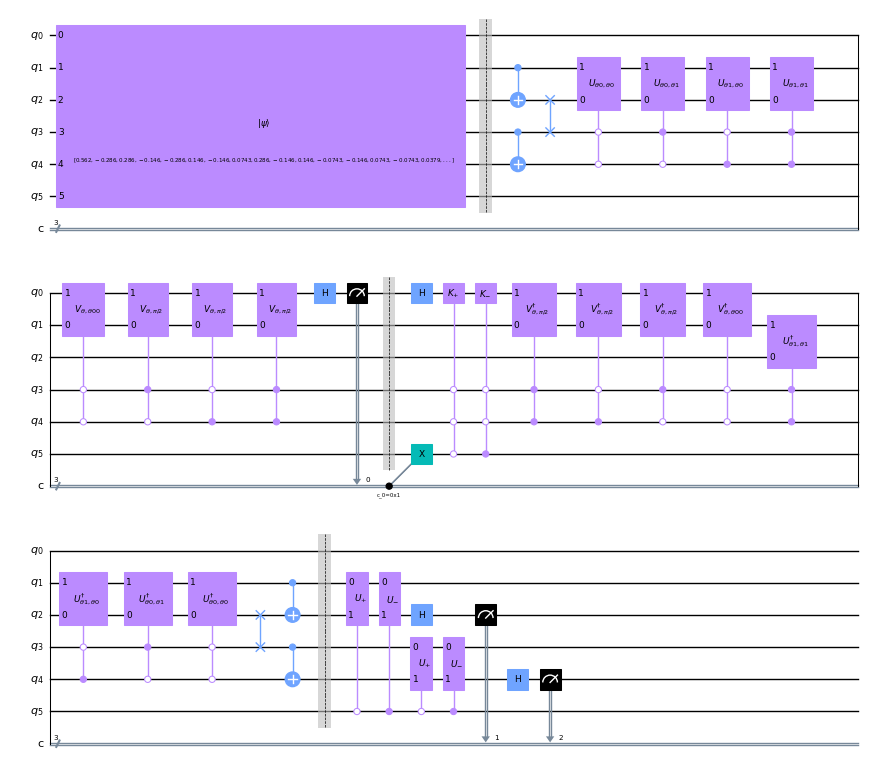

In [6]:
theta_mult = 0.6
theta = theta_mult * np.pi / 2
codeword_idx = 1

viz_params = {'visualize_flag': False,
              'plot_foldername': "plots/",
              'plot_filename_prefix': "th" + str(theta_mult) + "_cwd" + str(codeword_idx)}


decoder_input = Utils.get_channel_output(theta=theta, codeword_idx=codeword_idx)

bpqm_ckt = BPQM_Circuit(decoder_input, theta, viz_params)

bpqm_ckt.channel_combining_at_FN()

bpqm_ckt.channel_combining_at_VN()

bpqm_ckt.measure_q0()

bpqm_ckt.undo_measure_q0()
bpqm_ckt.undo_unitaries()

bpqm_ckt.decode_qubit_2_to_5()

bpqm_ckt.qc.draw(output="mpl", scale=0.5)

## **Measurement statistics.**

Running statevector simulator...


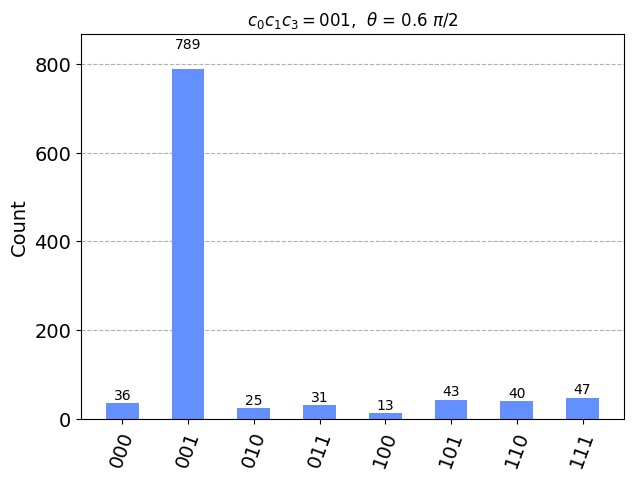

In [7]:
bpqm_ckt.simulate()
counts = bpqm_ckt.sim_result.get_counts(bpqm_ckt.qc_compiled)

# Measurement statistics
codeword = Utils.get_codebook()[codeword_idx]
plot_histogram(counts, title=f"$c_0 c_1 c_3 = ${codeword[3]}{codeword[1]}{codeword[0]},  $\\theta$ = {theta_mult} $\pi/2$")